# Sentiment Analysis on a Twitter dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast

torch.cuda.get_device_name(0)  # check if GPU is loaded


'NVIDIA GeForce RTX 2080 Super with Max-Q Design'

For the analysis we choose the "Twitter Sentiment Analysis" dataset developed by Sherif Hussein available on [Mendeley Data](https://data.mendeley.com/datasets/z9zw7nt5h2/1). It contains around 160k tweets labelled with one of three sentiments.

In [2]:
twitter = pd.read_csv("data/Twitter_Data.csv")
twitter = twitter.dropna()

twitter

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


We start by looking at the distribution of sentiments in the dataset:

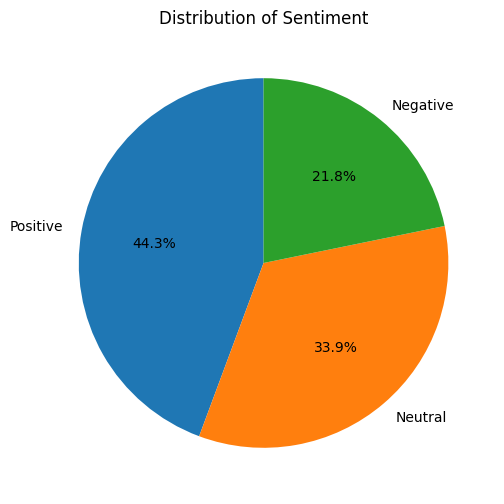

In [16]:
sentiment_counts = twitter['category'].value_counts()
sentiment_labels = sentiment_counts.index.map({
    -1.0: "Negative",
    0.0: "Neutral",
    1.0: "Positive"
})


plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment')
plt.show()

Before processing natural language with neural networks we first need to tokenize it. For this we use the state-of-the-art tokenizer BERT presented in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).

In [3]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,  # BERT has a maximum input length of 512 tokens
        return_tensors='pt'  # Return as PyTorch tensors
    )
    return encoding

tokenized_data = tokenize_data(twitter['clean_text'].tolist())
twitter['tokens'] = tokenized_data['input_ids'].tolist()

twitter

,clean_text,category,tokens
0,when modi promised “minimum government maximum...,-1.0,"[101, 2043, 16913, 2072, 5763, 1523, 6263, 223..."
1,talk all the nonsense and continue all the dra...,0.0,"[101, 2831, 2035, 1996, 14652, 1998, 3613, 203..."
2,what did just say vote for modi welcome bjp t...,1.0,"[101, 2054, 2106, 2074, 2360, 3789, 2005, 1691..."
3,asking his supporters prefix chowkidar their n...,1.0,"[101, 4851, 2010, 6793, 17576, 20209, 3211, 76..."
4,answer who among these the most powerful world...,1.0,"[101, 3437, 2040, 2426, 2122, 1996, 2087, 3928..."
...,...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0,"[101, 2339, 2122, 3429, 2575, 21665, 2015, 382..."
162976,dear rss terrorist payal gawar what about modi...,-1.0,"[101, 6203, 12667, 2015, 9452, 3477, 2389, 117..."
162977,did you cover her interaction forum where she ...,0.0,"[101, 2106, 2017, 3104, 2014, 8290, 7057, 2073..."
162978,there big project came into india modi dream p...,0.0,"[101, 2045, 2502, 2622, 2234, 2046, 2634, 1691..."


We can also look at a random sample to illustrate the tokenization process. One can observe that the token vector is padded with $0$, which ensures all vectors have the same length.

In [18]:
random_row = twitter.sample(n=1).iloc[0]

print("Clean Text:", random_row['clean_text'])
print("Tokens:", random_row['tokens'])

Clean Text: congress party fattu they chose second seat for rahul from where bjp weak they claim challengers modi then they should have chosen varanasi but the khandaan fattu 
Tokens: [101, 3519, 2283, 6638, 8525, 2027, 4900, 2117, 2835, 2005, 10958, 21886, 2013, 2073, 24954, 5410, 2027, 4366, 12932, 2015, 16913, 2072, 2059, 2027, 2323, 2031, 4217, 13075, 5162, 5332, 2021, 1996, 4967, 2850, 2319, 6638, 8525, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now we split the dataset into a training dataset, a test dataset and a validation dataset.

In [4]:
category_mapping = {-1.0: 0, 0.0: 1, 1.0: 2}
twitter['category'] = twitter['category'].map(category_mapping)

X = twitter['tokens'].tolist()  # Input features (tokens)
y = twitter['category'].tolist()  # Output labels (category)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Training set size: 130375
Validation set size: 16297
Test set size: 16297


Finally, we implement data loaders for our three datasets. This concludes the preprocessing of the data.

In [5]:
class TwitterDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        token_tensor = torch.tensor(self.tokens[idx], dtype=torch.long)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        return token_tensor, label_tensor

# Create Dataset objects
train_dataset = TwitterDataset(X_train, y_train)
val_dataset = TwitterDataset(X_val, y_val)
test_dataset = TwitterDataset(X_test, y_test)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Neural Bag of Words

The [Bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) is a simple natural language neural network model, which makes it a good starting point. Contrary to more advanced architectures, the word order is ignored.

In [20]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super(NBoW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        embedded = self.embedding(ids)
        pooled = embedded.mean(dim=1)
        prediction = self.fc(pooled)
        return prediction

vocab_size = 30522  # BERT's vocabulary size
embedding_dim = 768  # BERT's embedding size
output_dim = 3  # 3 output categories
pad_index = tokenizer.pad_token_id

# Instantiate the model
model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

The model has 23,443,203 trainable parameters


We now train our Neural Bag of Words model and save the weights to disk. The training takes a few minutes, so you can save time by skipping the model training and loading the model from disk.

In [21]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0

        for tokens, labels in train_loader:
            tokens, labels = tokens.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(tokens)

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

        # Validation
        evaluate_model(model, val_loader)

def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients
        for tokens, labels in val_loader:
            tokens, labels = tokens.to(device), labels.to(device)

            predictions = model(tokens)
            _, predicted_labels = torch.max(predictions, dim=1)

            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    print(f'Validation Accuracy: {accuracy:.2f}%')

In [23]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6)

# Save the model
torch.save(model.state_dict(), 'nbag.pth')


Epoch: 1/6, Loss: 0.5393
Validation Accuracy: 88.55%
Epoch: 2/6, Loss: 0.2762
Validation Accuracy: 90.86%
Epoch: 3/6, Loss: 0.2266
Validation Accuracy: 91.12%
Epoch: 4/6, Loss: 0.2049
Validation Accuracy: 91.12%
Epoch: 5/6, Loss: 0.1912
Validation Accuracy: 91.00%
Epoch: 6/6, Loss: 0.1818
Validation Accuracy: 91.04%


In [9]:
# Load the model
model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)
model.load_state_dict(torch.load('nbag.pth', weights_only=True))
model.eval()  # Set the model to evaluation mode
model.to(device)

NBoW(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (fc): Linear(in_features=768, out_features=3, bias=True)
)

Accuracy: 0.91


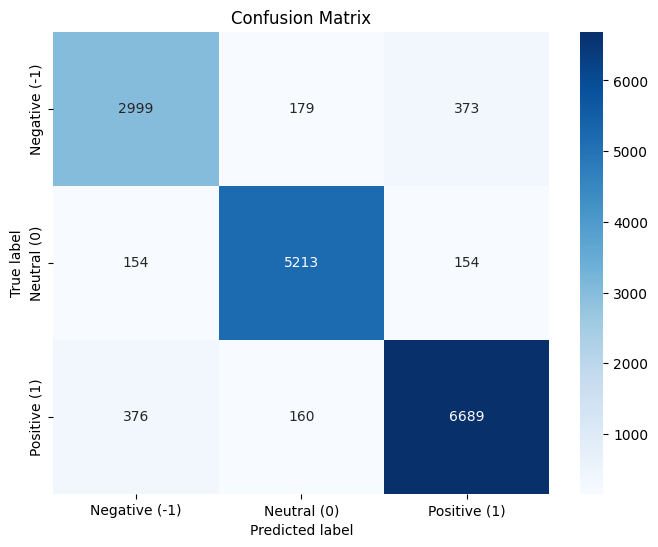

In [10]:
def evaluate_model_all(model, test_loader, device):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for tokens, labels in test_loader:
            tokens = tokens.to(device) 
            labels = labels.numpy()
            
            # Get model predictions
            logits = model(tokens)
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            predicted_classes = np.argmax(probabilities, axis=1)

            all_predictions.extend(predicted_classes)
            all_labels.extend(labels)

    return np.array(all_labels), np.array(all_predictions)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a list of class names
class_names = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']

# Evaluate the model and get predictions
y_true, y_pred = evaluate_model_all(model, test_loader, device)

accuracy = np.mean(y_true == y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)



The model achieves an accuracy of around $91 \%$, which is not bad for a model without any information about word ordering.

### Recurrent Neural Network

We now want to include the information contained in the word order, so for the next architecture we choose a [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network). These models are specifically designed for sequential data.

In [24]:
class RNN_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_index):
        super(RNN_GRU, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        
        # GRU layer
        self.gru = nn.GRU(embedding_dim,
                         hidden_dim,
                         num_layers=n_layers,
                         bidirectional=bidirectional,
                         batch_first=True,
                         dropout=dropout if n_layers > 1 else 0)
        
        # Fully connected layer
        # If bidirectional, multiply hidden_dim by 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, sentence length]
        
        # Embed the text
        # embedded shape: [batch size, sentence length, embedding dim]
        embedded = self.dropout(self.embedding(text))
        
        # Pass through GRU
        # output shape: [batch size, sentence length, hidden dim * n_directions]
        # hidden shape: [n_layers * n_directions, batch size, hidden dim]
        output, hidden = self.gru(embedded)
        
        # If bidirectional, concatenate the final forward and backward hidden states
        if isinstance(hidden, tuple):
            hidden = hidden[0]  # For LSTM
        
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        # Apply dropout to the final hidden state
        hidden = self.dropout(hidden)
        
        # Pass through linear layer
        # prediction shape: [batch size, output dim]
        prediction = self.fc(hidden)
        
        return prediction

# Improved hyperparameters
vocab_size = 30522  # BERT's vocabulary size
embedding_dim = 768  # BERT's embedding size
hidden_dim = 256    # Hidden dimension for GRU
output_dim = 3      # 3 output categories (negative, neutral, positive)
n_layers = 2        # Number of GRU layers
bidirectional = True  # Use bidirectional GRU
dropout = 0.3       # Dropout rate
pad_index = tokenizer.pad_token_id


# Instantiate the model
rnn_model = RNN_GRU(vocab_size, embedding_dim, hidden_dim, output_dim, 
                n_layers, bidirectional, dropout, pad_index)

print(f"The RNN model has {sum(p.numel() for p in rnn_model.parameters() if p.requires_grad):,} trainable parameters")

rnn_model.to(device)

criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)

The RNN model has 26,201,091 trainable parameters


In [25]:
# Train the model
train_model(rnn_model, train_loader, val_loader, criterion_rnn, optimizer_rnn, num_epochs=6)

# Save the model
torch.save(rnn_model.state_dict(), 'rnn.pth')

Epoch: 1/6, Loss: 0.3578
Validation Accuracy: 94.17%
Epoch: 2/6, Loss: 0.1812
Validation Accuracy: 95.38%
Epoch: 3/6, Loss: 0.1415
Validation Accuracy: 96.05%
Epoch: 4/6, Loss: 0.1263
Validation Accuracy: 96.23%
Epoch: 5/6, Loss: 0.1181
Validation Accuracy: 96.16%
Epoch: 6/6, Loss: 0.1157
Validation Accuracy: 96.41%


Again you can load the model from a save file to save time on training it.

In [27]:
# Load the model
rnn_model = RNN_GRU(vocab_size, embedding_dim, hidden_dim, output_dim, 
                n_layers, bidirectional, dropout, pad_index)
rnn_model.load_state_dict(torch.load('rnn.pth', weights_only=True))
rnn_model.eval()
rnn_model.to(device)

RNN_GRU(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (gru): GRU(768, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

RNN Model Accuracy: 0.96


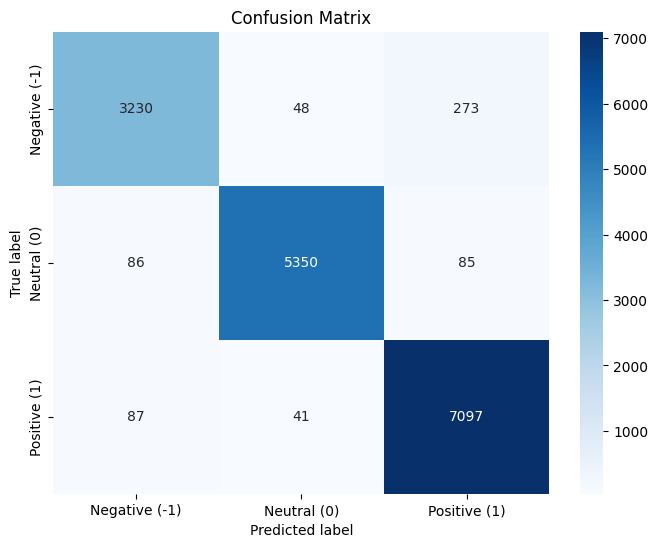

In [28]:
y_true_rnn, y_pred_rnn = evaluate_model_all(rnn_model, test_loader, device)

accuracy_rnn = np.mean(y_true_rnn == y_pred_rnn)
print(f"RNN Model Accuracy: {accuracy_rnn:.2f}")

plot_confusion_matrix(y_true_rnn, y_pred_rnn, class_names)

### Convolutional Neural Network

(c) Mia Müßig